## Constants and dataloading

In [90]:
import json
import smart_open
import pandas as pd
import os

FIGURE_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/figures"
TABLES_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/tables"
RESULTS_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/results"

model_name_to_path = {
    'dolma-1b': 'olmo/1b/olmo-small-dolma-150B-mcli-results',
    'dolma-7b': 'olmo/7b/dolma_v1_5-mix-mitch-ish',
    'pythia-1b': 'pythia/1b',
    'pythia-6.9b': 'pythia/7b',
    'rp-incite-7b': 'redpajama-incite/7b'
}

name_to_display = {
    'ppl_c4_en': 'C4',
    'ppl_falcon-refinedweb': 'Falcon',
    'ppl_mc4': 'MC4',
    'ppl_ptb': 'PTB',
    'ppl_wikitext_103': 'WikiText-103',
    'ppl_redpajama': 'RedPajama',
    'ppl_dolma-v1_5': 'Dolma V1.5',
    'ppl_pile': 'The Pile',
    'ppl_c4_100_domains': 'C4 100 Domains',
    'ppl_dolma_100_programing_languages': '100 PLs',
    'ppl_dolma_100_subreddits': '100 Subreddits',
    'ppl_ice_fixed': 'ICE',
    'ppl_m2d2_s2orc_unsplit': 'M2D2 S2ORC',
    'ppl_m2d2_wikipedia_unsplit': 'M2D2 Wikipedia',
    'ppl_manosphere_meta_sep': 'Manosphere',
    'ppl_twitterAAE_HELM_fixed': 'Twitter AAE',
    'model': 'Model',
    'model_size': 'Model Size',
    'split': 'Split',
    'tokens_seen': 'Tokens Seen',
    'training_dataset': 'Training Dataset',
    'training_steps': 'Training Steps',
    'bits_per_byte': 'Bits Per Byte',
    'ppl_tokens': 'Perplexity per Token',
    'All': 'All',
}

shared_cols = {
    'model',
    'model_size',
    'split',
    'tokens_seen',
    'training_dataset',
    'training_steps'
 }

non_domain_cols = {
    "date",
    "model",
    "model_kwargs",
    "full_model",
    "task",
    "processing_time",
    "num_instances",
    "tango_workspace",
    "tango_step",
    "model_max_length",
    "max_batch_tokens",
    "batch_size",
    "limit",
    "split",
    "random_subsample_seed",
    "model_size",
    "training_steps",
    "tokens_seen",
    "training_dataset"
}

fringe_domains = {
    'ppl_manosphere_meta_sep',
    'ppl_4chan_meta_sep',
    'ppl_gab'
}

standard_lm_benchmarks = {
    'ppl_c4_en',
    'ppl_falcon-refinedweb',
    'ppl_mc4',
    'ppl_ptb',
    'ppl_wikitext_103'
}

tasks_and_subdomain_reweighting = {
    'ppl_dolma-v1_5': { # from perplexity-eval/wimbd_stats_per_subdomain.sh
        "books": 5151989406 / 3092471692994, "ppl_c4_en": 174063495691/ 3092471692994, "common-crawl": (682871579682 + 801847275633 + 929094243502) / 3092471692994, "pes2o": 57171277321/ 3092471692994, "reddit_uniform": 79691540960/ 3092471692994, "stack_uniform": 358898022843/3092471692994, "wiki": 3682267956/3092471692994
        },
    'ppl_pile': { # from perplexity-eval/wimbd_stats_per_subdomain.sh
                    'ArXiv': 0.1021663383292594,
                    'BookCorpus2': 0.006922684974746704,
                    'Books3': 0.11430444331955997,
                    'DM_Mathematics': 0.021418015498677917,
                    'Enron_Emails': 0.001426531147330422,
                    'EuroParl': 0.008709394330168848,
                    'FreeLaw': 0.055446124418841794,
                    'Github': 0.09815765131220212,
                    'Gutenberg_PG-19': 0.020758335180918297,
                    'HackerNews': 0.006169988959995758,
                    'NIH_ExPorter': 0.0021734138919789394,
                    'OpenSubtitles': 0.016527839624960433,
                    'OpenWebText2': 0.09001673683420781,
                    'PhilPapers': 0.00367360871649158,
                    'Pile-CC': 0.1602808622426978,
                    'PubMed_Abstracts': 0.024288423952683613,
                    'PubMed_Central': 0.12685529942277587,
                    'StackExchange': 0.055784225862886144,
                    'USPTO_Backgrounds': 0.028646698997411003,
                    'Ubuntu_IRC': 0.011659962869647829,
                    'Wikipedia_en': 0.03656375466905958,
                    'YoutubeSubtitles': 0.008049665443498185
                },
    'ppl_redpajama': {'arxiv': 28 / 1210, 'books': 26 / 1210, 'c4': 175 / 1210, 'commoncrawl': 878 / 1210, 'github': 59 / 1210, 'stackexchange': 20 / 1210, 'wikipedia': 24 / 1210}
}

def standardize_model_metadata(row):
    if row['model'].startswith('s3://ai2-llm/checkpoints/1b/olmo-small-dolma-150B-mcli'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'model_kwargs' in row:
            assert row['model_kwargs'] == {'revision': None, 'trust_remote_code': True}
            del row['model_kwargs']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'olmo'
        row['model_size'] = 1177240704 # provided by Ananya non embedding params
        row['training_steps'] = int(original_model_name.split('/')[-1].split('-')[0].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 4325376 # max_sequence_length: 2048 * global_train_batch_size: 2112 = 4,325,376
        row['training_dataset'] = 'Dolma V1.5'
    elif row['model'].startswith('EleutherAI/pythia-1b'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'pythia'
        row['model_size'] = 805736448 # non-embedding params 
        if 'model_kwargs' in row:
            row['training_steps'] = int(row['model_kwargs']['revision'].replace('step', ''))
        else:
            row['training_steps'] = int(row['revision'].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 2097152 # from paper
        row['training_dataset'] = 'The Pile'

        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('EleutherAI/pythia-6.9b'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'pythia'
        row['model_size'] = 6444163072 # non-embedding params 
        if 'model_kwargs' in row:
            row['training_steps'] = int(row['model_kwargs']['revision'].replace('step', ''))
        else:
            row['training_steps'] = int(row['revision'].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 2097152 # from paper
        row['training_dataset'] = 'The Pile'

        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'] == ('togethercomputer/RedPajama-INCITE-7B-Base'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'rp-incite'
        row['model_size'] = 6855589888 # non-embedding params from sum([p.numel() for p in model.parameters() if p.dim() > 1])
        if 'model_kwargs' in row:
            row['tokens_seen'] = 1000000000000 if row['model_kwargs']['revision'] == '1t_tokens' else int(row['model_kwargs']['revision'].split('b')[0]) * 1000000000
        else:
            row['tokens_seen'] = 1000000000000 if row['revision'] == '1t_tokens' else int(row['revision'].split('b')[0]) * 1000000000
        row['training_steps'] = int(row['tokens_seen'] / 4000000) # from hf website "Gradient Accumulations: 8 (global batch size 4M tokens)"
        row['training_dataset'] = 'RedPajama'

        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('s3://ai2-llm/checkpoints/7b/v1_5-mix-mitch-ish-hf-tokenizer-olmo/'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'model_kwargs' in row:
            assert row['model_kwargs'] == {'revision': None, 'trust_remote_code': True}
            del row['model_kwargs']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'olmo'
        row['model_size'] = 7000000000 # todo get exact value
        row['training_steps'] = int(original_model_name.split('/')[-1].split('-')[0].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 4423680 # TODO CONFIRM max_sequence_length: 2048 * global_train_batch_size: 2160 = 4,423,680
        row['training_dataset'] = 'Dolma V1.5'
    else:
        pass
        # raise ValueError(f"Unknown model: {row['model']}")
    return row

def read_jsonl(path):
    with smart_open.open(path, 'rt') as fin:
        for line in fin:
            data = standardize_model_metadata(json.loads(line))
            yield data

all_standard_tasks = list(standard_lm_benchmarks) + list(tasks_and_subdomain_reweighting.keys())

domains_with_subdomains = set()
for sheet_name in os.listdir(os.path.join(RESULTS_DIR, model_name_to_path['dolma-1b'])):
    if sheet_name.endswith("subdomains.jsonl.gz") and not sheet_name.startswith("bits_per_byte"):
        domains_with_subdomains.add("_".join(sheet_name.split("_")[2:-1]))

domains_without_subdomains = set(pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['dolma-1b']), "ppl_metrics.jsonl.gz")))['task']) - domains_with_subdomains
domains_without_subdomains_clean = set(d for d in domains_without_subdomains if all(fringe_domain not in d for fringe_domain in fringe_domains))
domains_with_subdomains_clean = set(domains_with_subdomains) - fringe_domains

results_files_all = os.listdir(os.path.join(RESULTS_DIR, model_name_to_path['dolma-1b']))
results_files_clean = [f for f in results_files_all if all(fringe_domain not in f for fringe_domain in fringe_domains)]

In [2]:

# ppl_redpajama_token_count_avg_logits = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['dolma-1b']), "ppl_redpajama_token_count_avg_logits.jsonl.gz")))
# ppl_redpajama_token_count_avg_logits.head()
# ppl_token_ppl_twitterAAE_HELM_fixed_subdomains = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['dolma-1b']), "ppl_token_ppl_twitterAAE_HELM_fixed_subdomains.jsonl.gz")))
# ppl_token_ppl_twitterAAE_HELM_fixed_subdomains
# ppl_metrics = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['dolma-1b']), "ppl_metrics.jsonl.gz")))
# ppl_metrics.head()
ppl_token_ppl_twitterAAE_HELM_fixed_subdomains = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['pythia-6.9b']), "ppl_token_ppl_twitterAAE_HELM_fixed_subdomains.jsonl.gz")))
ppl_token_ppl_twitterAAE_HELM_fixed_subdomains

,date,model,task,num_instances,white,AA,split,model_size,training_steps,tokens_seen,training_dataset
0,2023-10-31 02:10:19 UTC,pythia,ppl_twitterAAE_HELM_fixed,50000,142.585846,381.313759,test,6444163072,10000,20971520000,The Pile
1,2023-10-31 02:10:19 UTC,pythia,ppl_twitterAAE_HELM_fixed,50000,126.115307,336.757999,test,6444163072,20000,41943040000,The Pile
2,2023-10-31 02:10:19 UTC,pythia,ppl_twitterAAE_HELM_fixed,50000,113.763558,296.049714,test,6444163072,30000,62914560000,The Pile
3,2023-10-31 02:10:19 UTC,pythia,ppl_twitterAAE_HELM_fixed,50000,112.578384,294.882677,test,6444163072,40000,83886080000,The Pile
4,2023-10-31 02:10:19 UTC,pythia,ppl_twitterAAE_HELM_fixed,50000,111.708442,298.132529,test,6444163072,50000,104857600000,The Pile
5,2023-10-31 02:10:19 UTC,pythia,ppl_twitterAAE_HELM_fixed,50000,108.816834,282.231798,test,6444163072,60000,125829120000,The Pile
6,2023-10-31 02:10:19 UTC,pythia,ppl_twitterAAE_HELM_fixed,50000,102.897909,267.181823,test,6444163072,70000,146800640000,The Pile
7,2023-10-31 02:10:19 UTC,pythia,ppl_twitterAAE_HELM_fixed,50000,103.626944,267.485831,test,6444163072,80000,167772160000,The Pile
8,2023-10-31 02:10:19 UTC,pythia,ppl_twitterAAE_HELM_fixed,50000,104.994152,276.389547,test,6444163072,90000,188743680000,The Pile
9,2023-10-31 02:10:19 UTC,pythia,ppl_twitterAAE_HELM_fixed,50000,101.555056,263.833079,test,6444163072,100000,209715200000,The Pile


## Common Funcs

In [60]:
from functools import reduce

def make_subdomain_of_task(model_path, task_names, metric_name):
    ppl_metrics = pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_metrics.jsonl.gz")))
    dfs = []
    assert set(task_names) <= set(ppl_metrics['task'])
    for task_name in task_names:
        task_df = ppl_metrics[ppl_metrics['task'] == task_name]
        new_df = task_df[list(shared_cols)].copy()
        new_df[task_name] = task_df[metric_name]
        dfs.append(new_df)
    
    return dfs

def get_metric_for_all_subdomains(model_path, sheet_names, metrics_name, include_non_subdomain_tasks=None, provided_dfs=None):
    dfs = [] if provided_dfs is None else provided_dfs
    if include_non_subdomain_tasks:
        dfs.extend(make_subdomain_of_task(model_path, include_non_subdomain_tasks, metrics_name))
    for k in sheet_names:
        if not k.endswith('subdomains.jsonl.gz'):
            continue
        if k.startswith(metrics_name):
            df = pd.DataFrame(read_jsonl(os.path.join(model_path, k)))
            
            df = df[list(df.columns.difference(non_domain_cols - shared_cols))]
            dfs.append(df)
    if len(dfs) == 0:
        raise ValueError(f"No dataframes found for {model_path} {sheet_names} {metrics_name}")
    
    # join all the dfs on the domain cols, by concatenating the domain cols
    merged_df = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), dfs)
    return merged_df

def get_metric_weighted_by_subdomains(all_subdomains_df, subdomain_weights, task_name):
    domain_cols = list(set(all_subdomains_df.columns) - shared_cols)
    new_df = all_subdomains_df[list(shared_cols)].copy()
    # subdomain_weights = {col_name: weight} so apply this to respective columns
    for col_name, weight in subdomain_weights.items():
        all_subdomains_df[col_name] = all_subdomains_df[col_name] * weight
    new_df[task_name] = all_subdomains_df[domain_cols].sum(axis=1)

    return new_df

def get_avg_over_all_subdomains(df):
    domain_cols = list(set(df.columns) - shared_cols)
    new_df = df[list(shared_cols)].copy()
    new_df['avg_over_subdomains'] = df[domain_cols].mean(axis=1)
    return new_df

def get_median_over_all_subdomains(df):
    domain_cols = list(set(df.columns) - shared_cols)
    new_df = df[list(shared_cols)].copy()
    new_df['median_over_subdomains'] = df[domain_cols].median(axis=1)
    return new_df

def get_win_rate_over_all_subdomains(df):
    domain_cols = list(set(df.columns) - shared_cols)
    new_df = df[list(shared_cols)].copy()
    new_df['win_rate_over_subdomains'] = df.apply(lambda row: sum(row[domain_cols] == df[domain_cols].min()), axis=1) / len(domain_cols)
    return new_df

def get_win_rate_over_all_subdomains_by_nearest(df, nearest_measure, max_distance):
    domain_cols = list(set(df.columns) - shared_cols)
    # sort df by nearest measure
    df = df.sort_values(by=[nearest_measure])
    # iterate over each row
    new_df = []
    row_buffer = []
    for i, row in df.iterrows():
        if len(row_buffer) == 0:
            row_buffer.append(row)
            continue
        elif row['model'] != row_buffer[0]['model'] and row['model_size'] != row_buffer[0]['model_size']:
            row_buffer.append(row)
            continue
        else:
            row_df = pd.DataFrame(row_buffer)
            if (row_df[nearest_measure].max() - row_df[nearest_measure].min() > max_distance):
                print(row_df[list(shared_cols)])
            if len(row_buffer) >1 and (row_df[nearest_measure].max() - row_df[nearest_measure].min() <= max_distance):
                assert len(row_df) == len(set(row_df[['model','model_size']]))
                row_df[f'win_rate_with_nearest'] = row_df.apply(lambda row: sum(row[domain_cols] == row_df[domain_cols].min()), axis=1) / len(domain_cols)
                new_df.append(row_df)
            row_buffer = []
            row_buffer.append(row)
    
    new_df = pd.concat(new_df)
    return new_df



    

## Exploration


In [4]:
# get subdomains in a file
all_subdomains_df = get_metric_for_all_subdomains(os.path.join(RESULTS_DIR, model_name_to_path['rp-incite-7b']), ['ppl_token_ppl_redpajama_subdomains.jsonl.gz'], "ppl", [])
set(all_subdomains_df.columns)-shared_cols

{'arxiv', 'books', 'c4', 'commoncrawl', 'github', 'stackexchange', 'wikipedia'}

## Standard Benchmarks

In [5]:
# # one subplot per model, with lines for each standard LM benchmark TODO obsolete
# import matplotlib.pyplot as plt
# import numpy as np

# # one subplot for each model
# rows = 2
# fig, axs = plt.subplots(len(model_name_to_path) // rows + len(model_name_to_path) % rows, rows , figsize=(10, 10), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

# # line chare for each model
# for i, (model_name, model) in enumerate(model_name_to_path.items()):
#     model_path = os.path.join(RESULTS_DIR, model)
#     reweighted_tasks_with_subdomains = []
#     for task, reweighting in tasks_and_subdomain_reweighting.items():
#         task_df = get_metric_for_all_subdomains(model_path, ['ppl_token_'+task+'_subdomains.jsonl.gz'], 'ppl_token')
#         if task == 'ppl_dolma-v1_5':
#             task_df = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), [task_df, get_metric_for_all_subdomains(model_path, [], 'ppl_token', ['ppl_c4_en'])])
#         reweighted_tasks_with_subdomains.append(get_metric_weighted_by_subdomains(task_df, reweighting, task))
#     all_subdomains = get_metric_for_all_subdomains(model_path, [], 'ppl_token', standard_lm_benchmarks, reweighted_tasks_with_subdomains)
#     for subdomain in list(standard_lm_benchmarks) + list(tasks_and_subdomain_reweighting.keys()):
#         x_axis = all_subdomains['tokens_seen'] / 1000000000
#         y_axis = all_subdomains[subdomain]
#         axs[i//rows][i%rows].plot(x_axis, y_axis, label=name_to_display[subdomain])
#     axs[i//rows][i%rows].set_xlabel("Tokens Seen (billions)")
#     axs[i//rows][i%rows].set_ylabel("Perplexity per Token")
#     axs[i//rows][i%rows].set_title(model_name)

# axs[-1][0].legend(loc='upper center', bbox_to_anchor=(1.0, -0.2),
#         ncol=3, fancybox=True, shadow=True)
# plt.show()

# # output as pdf
# fig.savefig(os.path.join(FIGURE_DIR,'standard_benchmarks_by_models.pdf'), bbox_inches='tight', dpi=300)


In [6]:
def get_task_metric_for_all_models(model_name_to_path, task_name, metric_name):
    models_ppl_token = []
    for i, (model_name, model) in enumerate(model_name_to_path.items()):
        if task_name in tasks_and_subdomain_reweighting:
            reweighting = tasks_and_subdomain_reweighting[task_name]
            task_df = get_metric_for_all_subdomains(os.path.join(RESULTS_DIR, model), [metric_name+'_'+task_name+'_subdomains.jsonl.gz'], metric_name)
            if task_name == 'ppl_dolma-v1_5':
                task_df = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), [task_df, get_metric_for_all_subdomains(os.path.join(RESULTS_DIR, model), [], metric_name, ['ppl_c4_en'])])
            models_ppl_token.append(get_metric_weighted_by_subdomains(task_df, reweighting, task_name))
        elif task_name in standard_lm_benchmarks:
            models_ppl_token.append(get_metric_for_all_subdomains(os.path.join(RESULTS_DIR, model), [], metric_name, {task_name}))
        else:
            raise ValueError(f"Unknown task: {task_name}")
    models_ppl_token = pd.concat(models_ppl_token)
    return models_ppl_token

In [7]:
# table with a column for each standard benchmark, where cells are final model checkpoints ranked by their perplexity on that benchmark
metric_name = 'bits_per_byte'
all_tasks_all_models = []
for i, task_name in enumerate(all_standard_tasks):
    all_tasks_all_models.append(get_task_metric_for_all_models(model_name_to_path, task_name, metric_name))
all_subdomains = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), all_tasks_all_models)
all_subdomains = all_subdomains.sort_values(by=['tokens_seen']).groupby(['model', 'model_size']).last().reset_index()
all_subdomains = all_subdomains.drop(columns=['tokens_seen','training_steps','split'])
all_subdomains.rename(columns=name_to_display, inplace=True)
column_format = ('p{'+ str(1/ len(all_subdomains.columns)*.5)+'\\textwidth}') * len(all_subdomains.columns)
all_subdomains.to_latex(os.path.join(TABLES_DIR, 'standard_benchmarks_by_models.tex'), index=False, float_format="%.2f", column_format=column_format, formatters={'Model Size': lambda x: f"{x/1000000000:.2f}B"})
all_subdomains

,Model,Model Size,Training Dataset,WikiText-103,PTB,Falcon,C4,MC4,Dolma V1.5,The Pile,RedPajama
0,olmo,1177240704,Dolma V1.5,0.842115,0.954084,0.921274,0.856144,0.880365,0.838594,0.855929,0.741112
1,olmo,7000000000,Dolma V1.5,0.724685,0.821363,0.828979,0.767916,0.784953,0.743694,0.746224,0.647669
2,pythia,805736448,The Pile,0.815954,1.001298,0.959420,0.917404,0.936631,0.909873,0.727471,0.740079
3,pythia,6444163072,The Pile,0.703718,0.883502,0.866617,0.829402,0.838511,0.826310,0.631124,0.657675
4,rp-incite,6855589888,RedPajama,0.664428,0.835356,0.811612,0.740752,0.771106,0.768904,0.704655,0.560166


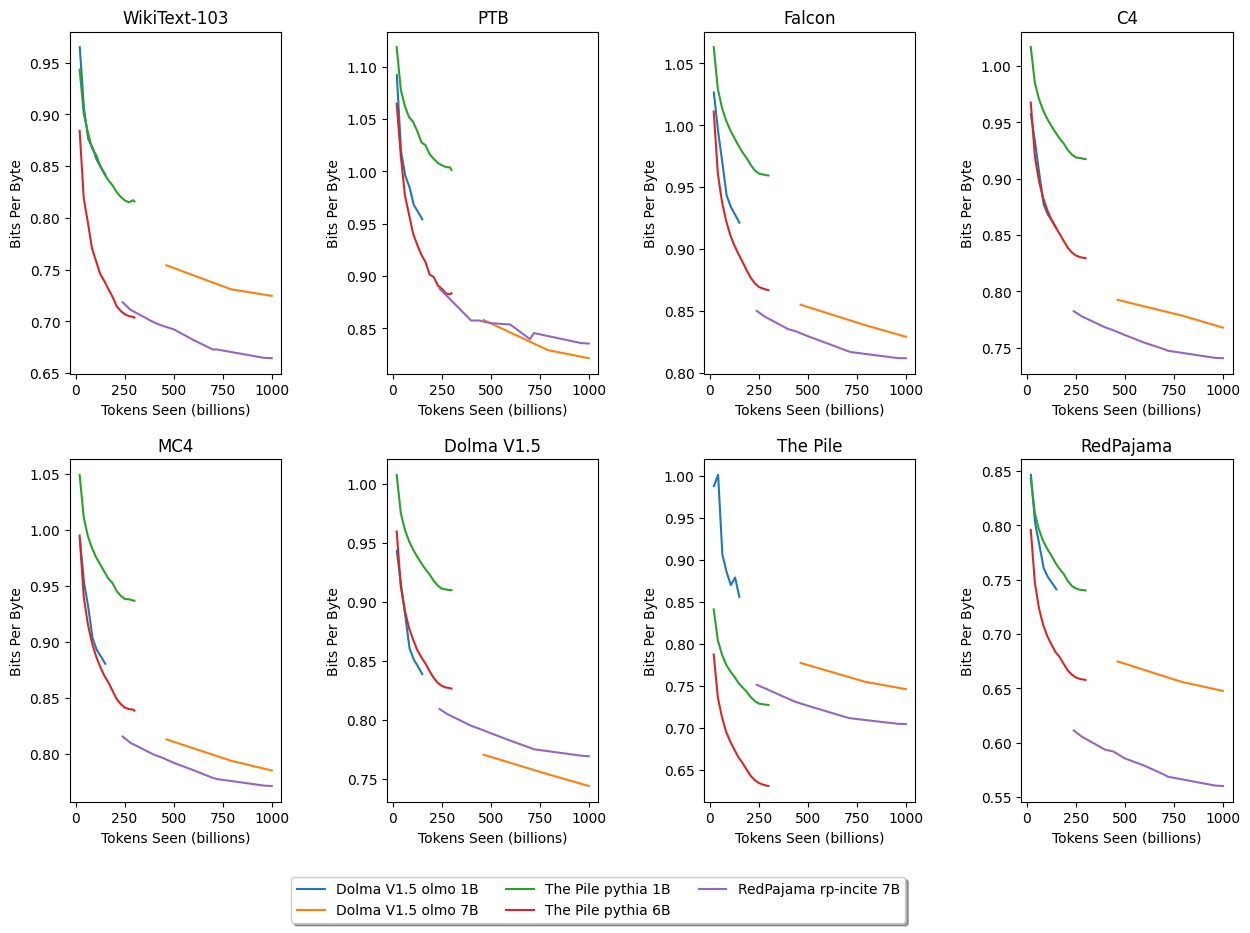

In [8]:
# all models over just one task

import matplotlib.pyplot as plt
import numpy as np

# one subplot for each task
fig, axs = plt.subplots(len(all_standard_tasks)//4, 4, figsize=(15, 10), gridspec_kw={'hspace': 0.25, 'wspace': 0.5})

metric_name = 'bits_per_byte'
for i, task_name in enumerate(all_standard_tasks):
    

    models_over_one_task = get_task_metric_for_all_models(model_name_to_path, task_name, metric_name)

    for (model, model_size, training_dataset), model_df in models_over_one_task.groupby(['model', 'model_size', 'training_dataset']):
        x_axis = model_df['tokens_seen'] / 1000000000
        y_axis = model_df[task_name]
        axs[i//4][i%4].plot(x_axis, y_axis, label=(training_dataset+' '+model+ f" {model_size/1000000000:.0f}B"))
    axs[i//4][i%4].set_xlabel("Tokens Seen (billions)")
    axs[i//4][i%4].set_ylabel(name_to_display[metric_name])
    axs[i//4][i%4].set_title(name_to_display[task_name])
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(2.5, -0.2),
        ncol=3, fancybox=True, shadow=True)
        # plt.plot(model_df['tokens_seen'] / 1000000000, model_df[task_name], label=(training_dataset+' '+model+ f" {model_size/1000000000:.0f}B"))
    # plt.legend()
# models_over_one_task = get_task_metric_for_all_models(model_name_to_path, 'ppl_dolma-v1_5', 'bits_per_byte')
# models_over_one_task

fig.savefig(os.path.join(FIGURE_DIR,'models_by_standard_benchmark.pdf'), bbox_inches='tight', dpi=300)


## Multi-domain Robustness

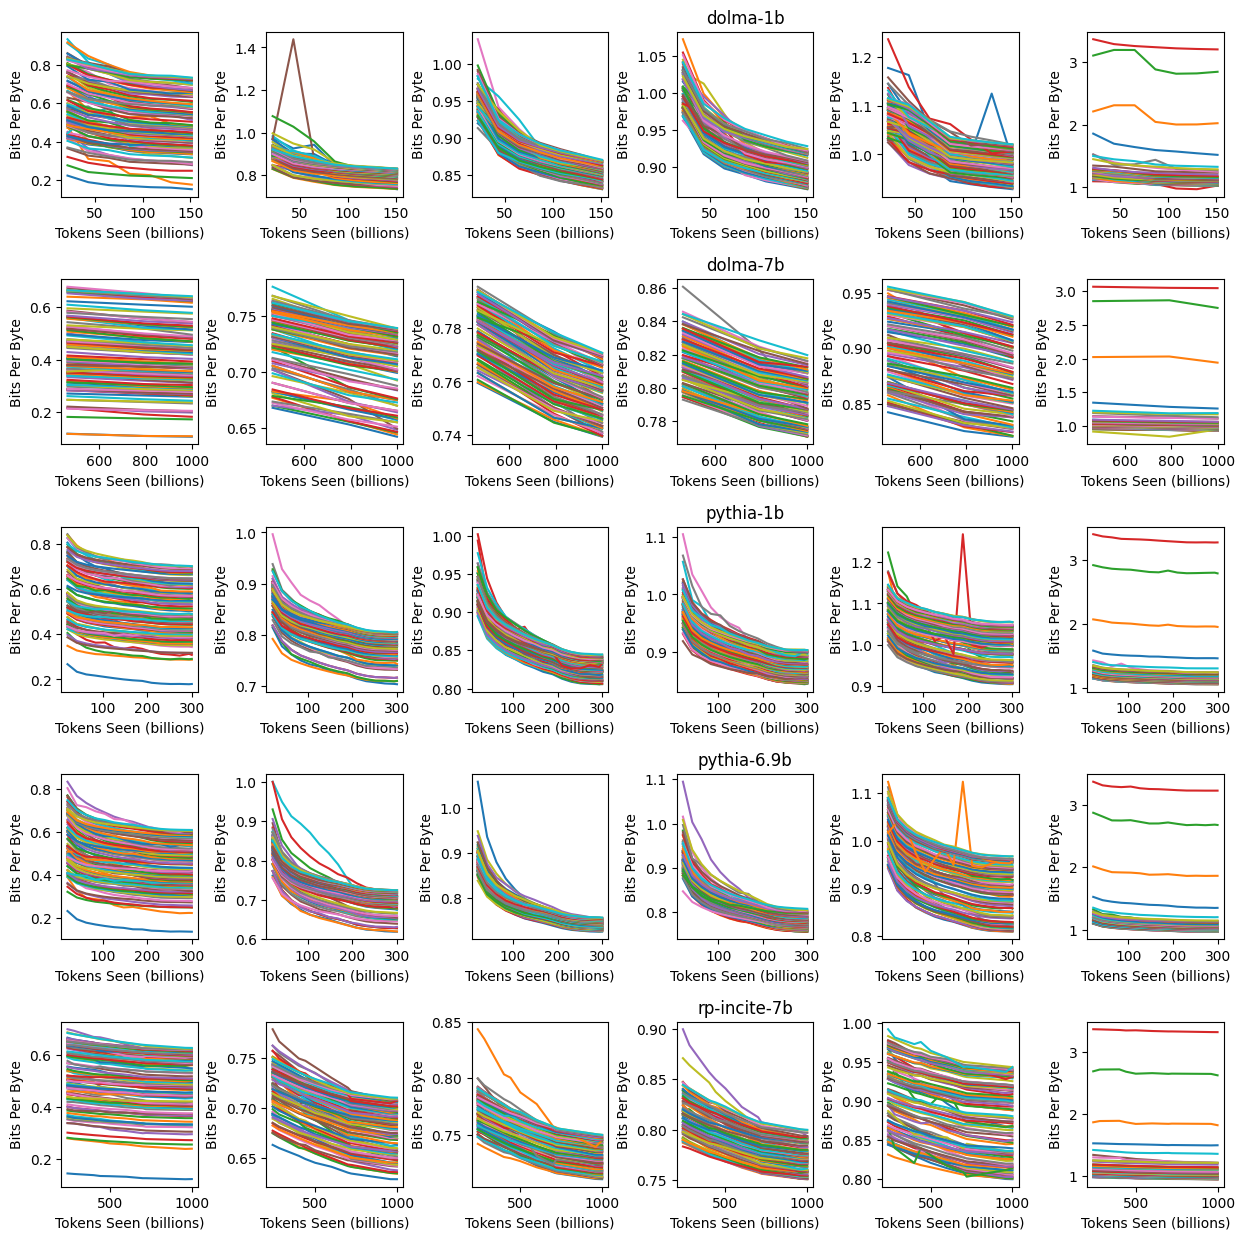

In [9]:
# one subplot per model, with lines for each subdomain

import matplotlib.pyplot as plt
import numpy as np

metric_name = 'bits_per_byte'

# one subplot for each model
fig, axs = plt.subplots(len(model_name_to_path), 6, figsize=(15, 15), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

# line chare for each model
for i, (model_name, model) in enumerate(model_name_to_path.items()):
    model_path = os.path.join(RESULTS_DIR, model)
    all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, metric_name, domains_without_subdomains_clean)
    max_tokens_seen_row = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()].reset_index(drop=True).drop(columns=shared_cols).T.rename(columns={0: 'metric'})
    domains_by_final_ppl = list(max_tokens_seen_row.sort_values(by='metric', axis=0).index)
    
    for j in range(6):
        for subdomain in domains_by_final_ppl[j*100:j*100+100]:
            x_axis = all_subdomains['tokens_seen'] / 1000000000
            y_axis = all_subdomains[subdomain]
            axs[i][j].plot(x_axis, y_axis, label=subdomain)
        axs[i][j].set_xlabel("Tokens Seen (billions)")
        axs[i][j].set_ylabel(name_to_display[metric_name])
    # axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, .95),
    #       ncol=3, fancybox=True, shadow=True)
    axs[i][3].set_title(model_name)
plt.show()

fig.savefig(os.path.join(FIGURE_DIR,'curves_for_all_subdomains.pdf'), bbox_inches='tight', dpi=300)


In [99]:
# a table ranking models by macro avg or win rate over subdomains from given tasks
def get_task_subdomains_results_files(results_files, metric_name, task_name):
    if task_name == 'All':
        return results_files_clean
    return [f for f in results_files if f.startswith(metric_name) and f.endswith(task_name + '_subdomains.jsonl.gz')]


def make_ranking_table(agg_function, metric_name, model_name_to_path, include_all_checkpoints=False, tasks=None):    
    tasks = list(domains_with_subdomains_clean) + ['All'] if tasks is None else tasks
    tasks_to_files = {
        task: get_task_subdomains_results_files(results_files_clean, metric_name, task) for task in tasks
    }

    assert agg_function in {get_avg_over_all_subdomains, get_win_rate_over_all_subdomains, get_median_over_all_subdomains}
    if include_all_checkpoints:
        assert agg_function != get_win_rate_over_all_subdomains, 'win rates dont make sense for all checkpoints'
    all_dfs = []
    for task, files in tasks_to_files.items():
        all_models_dfs = []
        for i, (model_name, model) in enumerate(model_name_to_path.items()):
            model_path = os.path.join(RESULTS_DIR, model)
            try:
                task_all_subdomains = get_metric_for_all_subdomains(model_path, files, metric_name)
            except ValueError as e:
                raise ValueError(f"Error for {task} {model_name} {model_path} {files}") from e
            # get just the final checkpoints by tokens seen for each model
            if not include_all_checkpoints:
                task_all_subdomains = task_all_subdomains.sort_values(by=['tokens_seen']).groupby(['model','model_size']).last().reset_index()
            all_models_dfs.append(task_all_subdomains)
        assert len(all_models_dfs), f"empty for {task}"
        all_models_dfs = pd.concat(all_models_dfs)
        all_models_dfs = agg_function(all_models_dfs)
        if 'avg_over_subdomains' in all_models_dfs:
            all_models_dfs.rename(columns={'avg_over_subdomains': task}, inplace=True)
        if 'win_rate_over_subdomains' in all_models_dfs:
            all_models_dfs.rename(columns={'win_rate_over_subdomains': task}, inplace=True)
        if 'median_over_subdomains' in all_models_dfs:
            all_models_dfs.rename(columns={'median_over_subdomains': task}, inplace=True)
        all_dfs.append(all_models_dfs)
    all_dfs = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), all_dfs)

    return all_dfs


In [100]:
metric_name = 'bits_per_byte'
model_name_to_path_1b = {k: v for k, v in model_name_to_path.items() if '1b' in k}
rankings_table = make_ranking_table(get_win_rate_over_all_subdomains, metric_name, model_name_to_path_1b).drop(columns=['tokens_seen','training_steps','split'])
rankings_table.rename(columns=name_to_display, inplace=True)
column_format = ('p{'+ str(1/ len(rankings_table.columns)*.5)+'\\textwidth}') * len(rankings_table.columns)
formaters = {name_to_display['model_size']: lambda x: f"{x/1000000000:.0f}B"}
rankings_table.to_latex(os.path.join(TABLES_DIR, 'final_checkpoints_1b_win_rates_per_tasks.tex'), index=False, float_format="%.2f", column_format=column_format, formatters=formaters)
rankings_table

,Model Size,Training Dataset,Model,The Pile,100 PLs,Twitter AAE,Dolma V1.5,M2D2 Wikipedia,100 Subreddits,RedPajama,ICE,M2D2 S2ORC,C4 100 Domains,All
0,1177240704,Dolma V1.5,olmo,0.0,0.5,0.0,0.5,0.122449,1.0,0.285714,0.588235,0.0,0.909091,0.458699
1,805736448,The Pile,pythia,1.0,0.5,1.0,0.5,0.877551,0.0,0.714286,0.411765,1.0,0.090909,0.541301


In [101]:
metric_name = 'bits_per_byte'
model_name_to_path_7b = {k: v for k, v in model_name_to_path.items() if '7b' in k or '6.9b' in k}
rankings_table = make_ranking_table(get_win_rate_over_all_subdomains, metric_name, model_name_to_path_7b).drop(columns=['tokens_seen','training_steps','split'])
rankings_table.rename(columns=name_to_display, inplace=True)
column_format = ('p{'+ str(1/ len(rankings_table.columns)*.5)+'\\textwidth}') * len(rankings_table.columns)
formaters = {name_to_display['model_size']: lambda x: f"{x/1000000000:.0f}B"}
rankings_table.to_latex(os.path.join(TABLES_DIR, 'final_checkpoints_7b_win_rates_per_tasks.tex'), index=False, float_format="%.2f", column_format=column_format, formatters=formaters)
rankings_table

,Model Size,Training Dataset,Model,The Pile,100 PLs,Twitter AAE,Dolma V1.5,M2D2 Wikipedia,100 Subreddits,RedPajama,ICE,M2D2 S2ORC,C4 100 Domains,All
0,7000000000,Dolma V1.5,olmo,0.000000,0.92,0.0,0.500000,0.000000,0.91,0.000000,0.0,0.000000,0.080808,0.340949
1,6444163072,The Pile,pythia,0.772727,0.07,0.0,0.333333,0.081633,0.00,0.142857,0.0,0.856287,0.010101,0.307557
2,6855589888,RedPajama,rp-incite,0.227273,0.01,1.0,0.166667,0.918367,0.09,0.857143,1.0,0.143713,0.909091,0.351494


In [102]:
metric_name = 'bits_per_byte'
rankings_table = make_ranking_table(get_avg_over_all_subdomains, metric_name, model_name_to_path,).drop(columns=['tokens_seen','training_steps','split'])
rankings_table.rename(columns=name_to_display, inplace=True)
column_format = ('p{'+ str(1/ len(rankings_table.columns)*.5)+'\\textwidth}') * len(rankings_table.columns)
formaters = {name_to_display['model_size']: lambda x: f"{x/1000000000:.0f}B"}
rankings_table.to_latex(os.path.join(TABLES_DIR, 'final_checkpoints_avg_ppl_per_tasks.tex'), index=False, float_format="%.2f", column_format=column_format, formatters=formaters)
rankings_table

,Model Size,Training Dataset,Model,The Pile,100 PLs,Twitter AAE,Dolma V1.5,M2D2 Wikipedia,100 Subreddits,RedPajama,ICE,M2D2 S2ORC,C4 100 Domains,All
0,1177240704,Dolma V1.5,olmo,0.948531,0.557213,2.434988,0.833399,0.849348,1.028866,0.823881,1.010663,0.876809,0.837717,0.849338
1,7000000000,Dolma V1.5,olmo,0.831726,0.448941,2.343737,0.734617,0.748416,0.936442,0.709661,0.914748,0.775175,0.750446,0.750212
2,805736448,The Pile,pythia,0.774263,0.580358,2.372575,0.836086,0.828407,1.075046,0.748954,1.009054,0.828267,0.868707,0.842965
3,6444163072,The Pile,pythia,0.665876,0.503091,2.266787,0.748834,0.725808,0.986651,0.660064,0.923252,0.748226,0.778376,0.756667
4,6855589888,RedPajama,rp-incite,0.791607,0.581687,2.222359,0.735800,0.690752,0.960311,0.603225,0.889732,0.761082,0.713839,0.758243


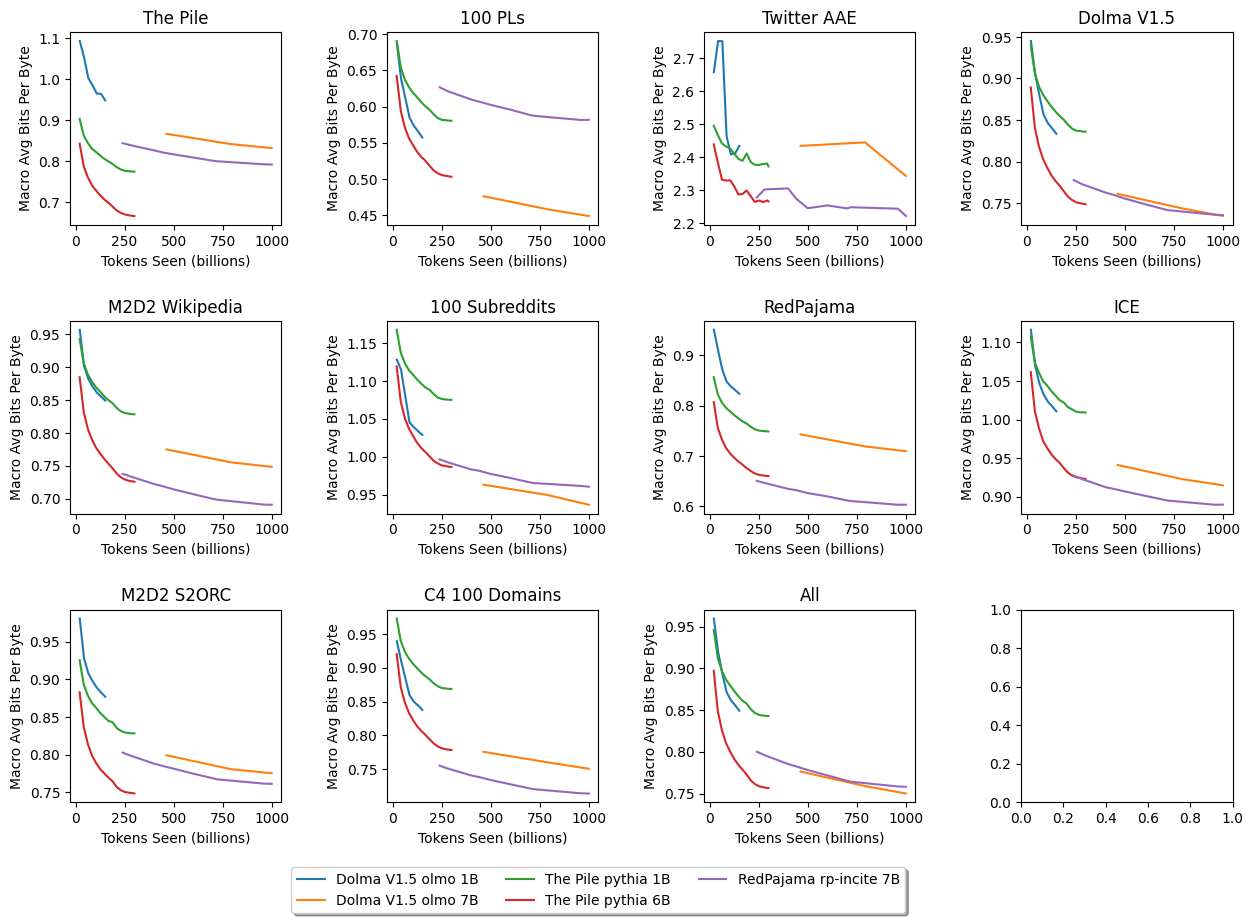

In [103]:
import matplotlib.pyplot as plt
import numpy as np

cols = 4
# one subplot for each task
fig, axs = plt.subplots(len(list(domains_with_subdomains_clean) + ['All'])//cols + int(len(list(domains_with_subdomains_clean) + ['All'])//cols < len(list(domains_with_subdomains_clean) + ['All'])/cols), cols, figsize=(15, 10), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

metric_name = 'bits_per_byte'
for i, task_name in enumerate(list(domains_with_subdomains_clean) + ['All']):
    
    models_over_one_task = make_ranking_table(get_avg_over_all_subdomains, metric_name, model_name_to_path,include_all_checkpoints=True, tasks=[task_name])

    for (model, model_size, training_dataset), model_df in models_over_one_task.groupby(['model', 'model_size', 'training_dataset']):
        x_axis = model_df['tokens_seen'] / 1000000000
        y_axis = model_df[task_name]
        axs[i//cols][i%cols].plot(x_axis, y_axis, label=(training_dataset+' '+model+ f" {model_size/1000000000:.0f}B"))
    axs[i//cols][i%cols].set_xlabel("Tokens Seen (billions)")
    axs[i//cols][i%cols].set_ylabel("Macro Avg " +name_to_display[metric_name])
    axs[i//cols][i%cols].set_title(name_to_display[task_name])
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(2.5, -0.3),
        ncol=3, fancybox=True, shadow=True)

fig.savefig(os.path.join(FIGURE_DIR,'models_by_macro_subdomains.pdf'), bbox_inches='tight', dpi=300)

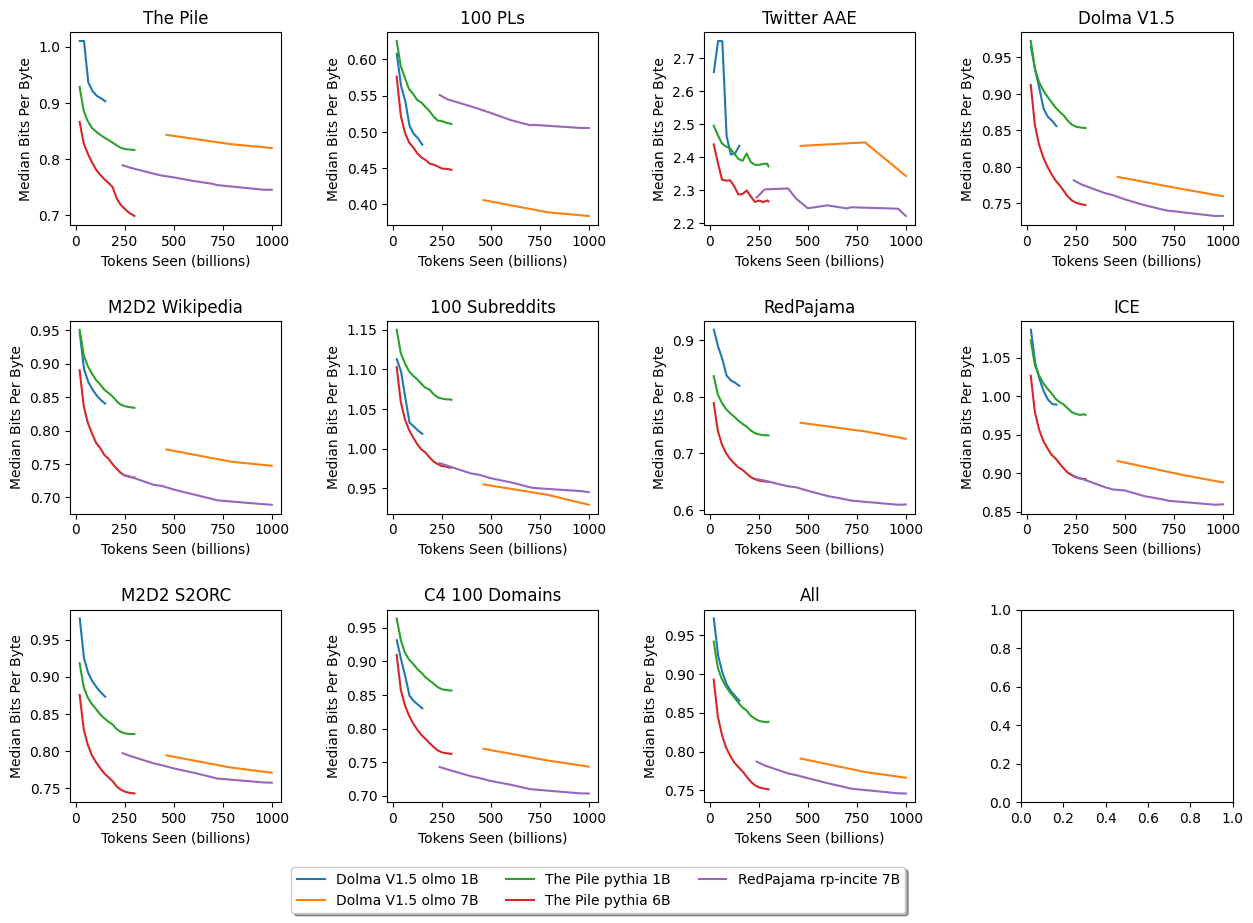

In [104]:
import matplotlib.pyplot as plt
import numpy as np

cols = 4
# one subplot for each task
fig, axs = plt.subplots(len(list(domains_with_subdomains_clean) + ['All'])//cols + int(len(list(domains_with_subdomains_clean) + ['All'])//cols < len(list(domains_with_subdomains_clean) + ['All'])/cols), cols, figsize=(15, 10), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

metric_name = 'bits_per_byte'
for i, task_name in enumerate(list(domains_with_subdomains_clean) + ['All']):
    
    models_over_one_task = make_ranking_table(get_median_over_all_subdomains, metric_name, model_name_to_path,include_all_checkpoints=True, tasks=[task_name])

    for (model, model_size, training_dataset), model_df in models_over_one_task.groupby(['model', 'model_size', 'training_dataset']):
        x_axis = model_df['tokens_seen'] / 1000000000
        y_axis = model_df[task_name]
        axs[i//cols][i%cols].plot(x_axis, y_axis, label=(training_dataset+' '+model+ f" {model_size/1000000000:.0f}B"))
    axs[i//cols][i%cols].set_xlabel("Tokens Seen (billions)")
    axs[i//cols][i%cols].set_ylabel("Median " +name_to_display[metric_name])
    axs[i//cols][i%cols].set_title(name_to_display[task_name])
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(2.5, -0.3),
        ncol=3, fancybox=True, shadow=True)

fig.savefig(os.path.join(FIGURE_DIR,'models_by_macro_subdomains.pdf'), bbox_inches='tight', dpi=300)

### Non-aggregated subdomain results

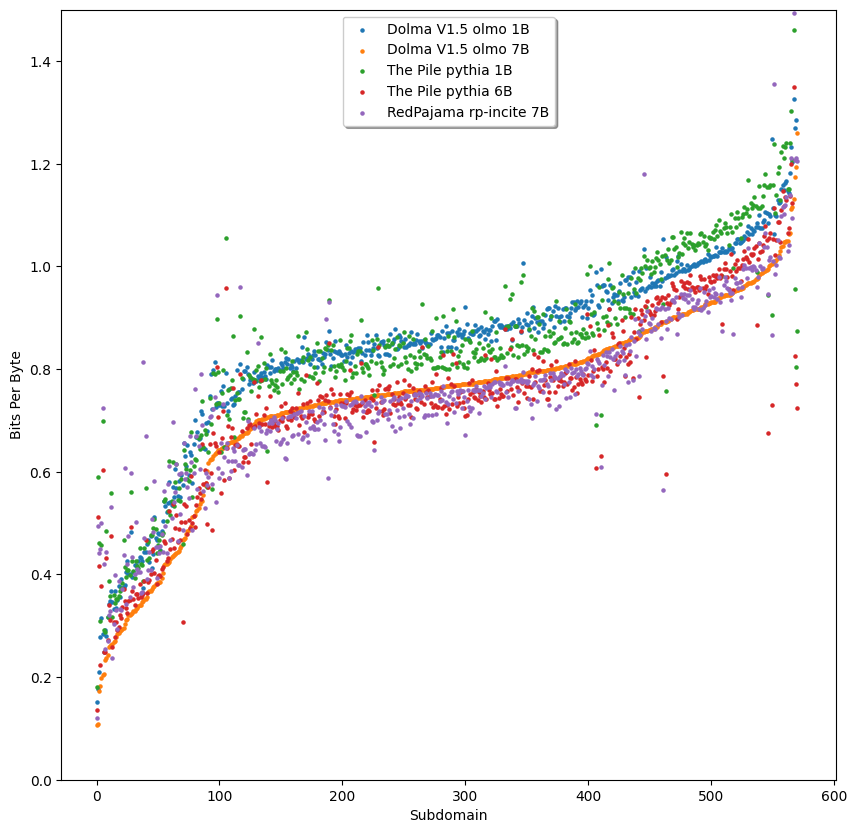

In [146]:
# sort domains by their BPB on the final checkpoint of Dolma 7b, then scatter plot for each model in its own color ordered that way
metric_name = 'bits_per_byte'

# get subdomains in order of a model's BPB on the final checkpoint
model_name = 'dolma-7b'
model = model_name_to_path[model_name]
model_path = os.path.join(RESULTS_DIR, model)
all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, metric_name, domains_without_subdomains_clean)
unaggred_subdomains= all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()]
tmp_df = unaggred_subdomains.drop(columns=shared_cols)
assert len(tmp_df) == 1
dolma_domains_as_rows = tmp_df.T.rename(columns={tmp_df.T.columns[0]: 'metric'}).sort_values(by='metric', axis=0).index

# get all subdomains
unaggred_subdomains = []
for i, (model_name, model) in enumerate(model_name_to_path.items()):
    model_path = os.path.join(RESULTS_DIR, model)
    all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, metric_name, domains_without_subdomains_clean)
    unaggred_subdomains.append(all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()])

unaggred_subdomains = pd.concat(unaggred_subdomains)
sorted_unaggred_subdomains = unaggred_subdomains[list(shared_cols) + list(dolma_domains_as_rows)]

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

for (model, model_size, training_dataset), model_df in sorted_unaggred_subdomains.groupby(['model', 'model_size', 'training_dataset']):
    y_axis = model_df[list(dolma_domains_as_rows)].values[0]
    x_axis = np.arange(len(dolma_domains_as_rows))
    # smaller scatter point size
    axs.scatter(x_axis, y_axis, label=(training_dataset+' '+model+ f" {model_size/1000000000:.0f}B"), s=5)
axs.set_xlabel("Subdomain")
axs.set_ylabel(name_to_display[metric_name])
axs.set_ylim(0, 1.5)
axs.legend(loc='upper center', ncol=1, fancybox=True, shadow=True)


    


In [ ]:
# do scatter plot colored by task for one model to show where tasks are in the performance distribution

In [ ]:
# do scatter plot with all models for just one task at a time

# AS FAR AS I GOT adding multi-model support

<Axes: >

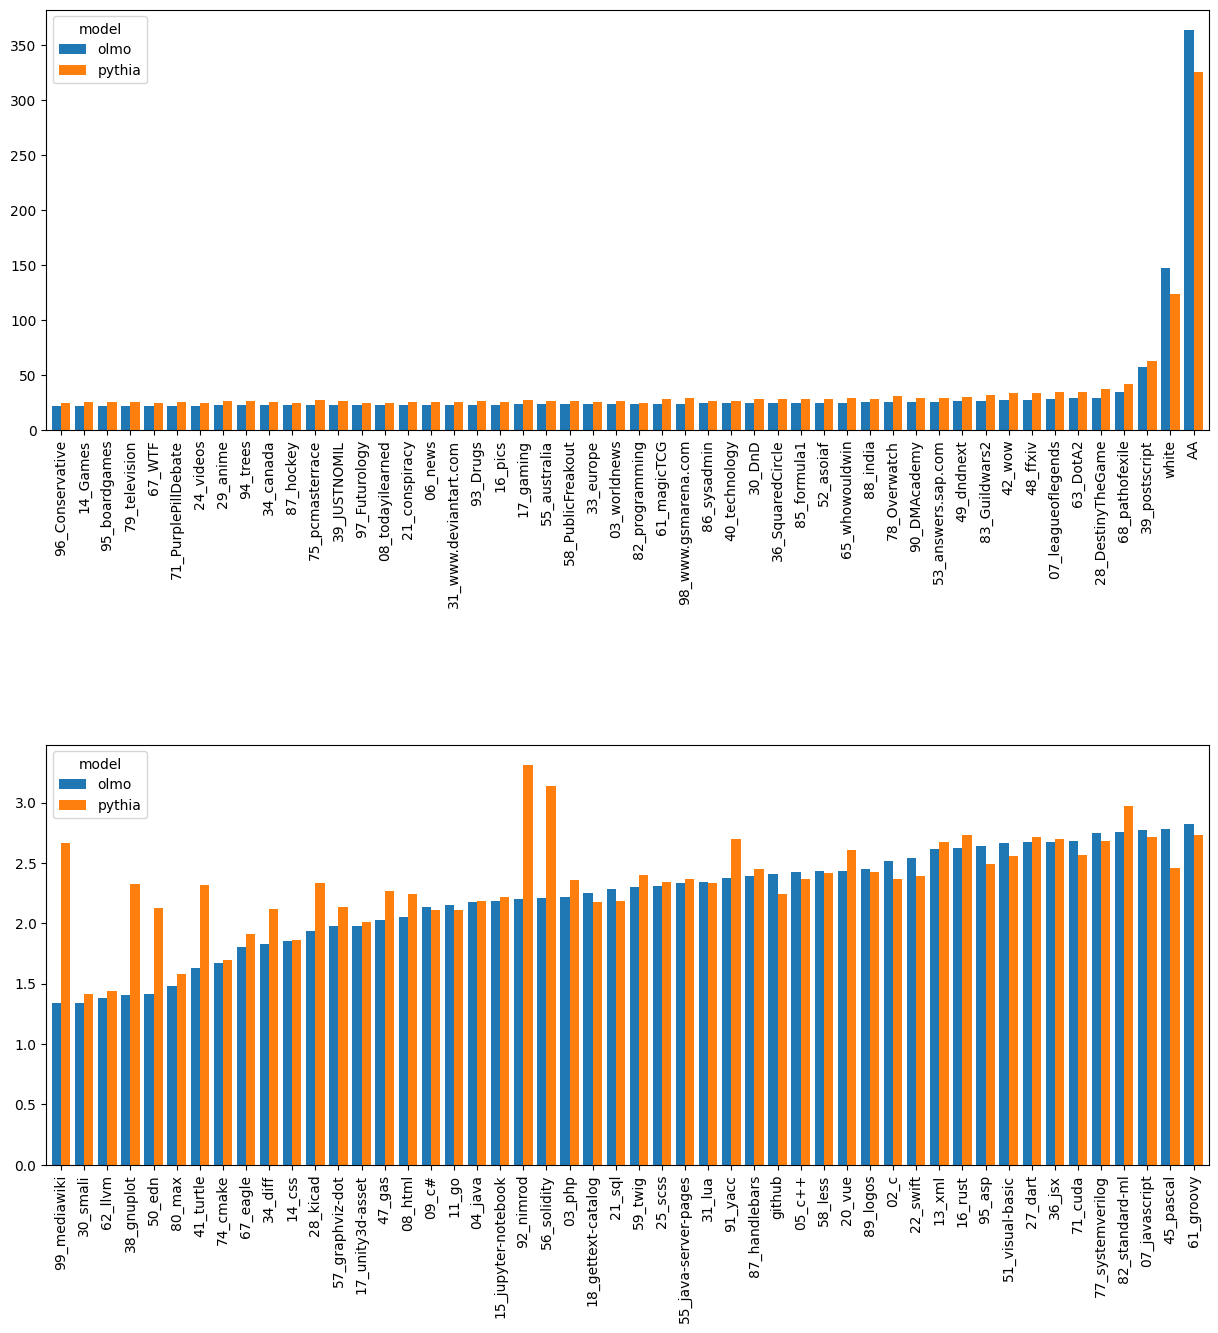

In [106]:
# bar chart over domains (no labels) of final dolma and pythia model

# bar chart of win rate over all final models
model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

# concat the two dataframes
all_subdomains = pd.concat([pythia_all_subdomains, dolma_all_subdomains])

# get the max 'tokens_seen' for each model
all_subdomains = all_subdomains.sort_values(by=['tokens_seen']).groupby('model').last().reset_index()

# sort domain columns by perplexity for dolma
dolma_domains_as_rows = all_subdomains[all_subdomains['model'] == 'olmo'].drop(columns=shared_cols).T.rename(columns={0: 'metric'})
domains_by_dolma_ppl = list(dolma_domains_as_rows.sort_values(by='metric', axis=0).index)


# bar chart over domains for both models


# make 3 subplots with more space between plts
fig, axs = plt.subplots(2, 1, figsize=(15, 15), gridspec_kw={'hspace': 0.75})
# ax = domain_data_by_dolma_order.T.plot.bar(width=.8)
# in first subplot, plot the top 50 domains by dolma ppl
domain_data_by_dolma_order = all_subdomains[['model'] + domains_by_dolma_ppl[-50:]].set_index('model')
domain_data_by_dolma_order.T.plot.bar(width=.8, ax=axs[0])

domain_data_by_dolma_order = all_subdomains[['model'] + domains_by_dolma_ppl[:50]].set_index('model')
domain_data_by_dolma_order.T.plot.bar(width=.8, ax=axs[1])



(0.0, 50.0)

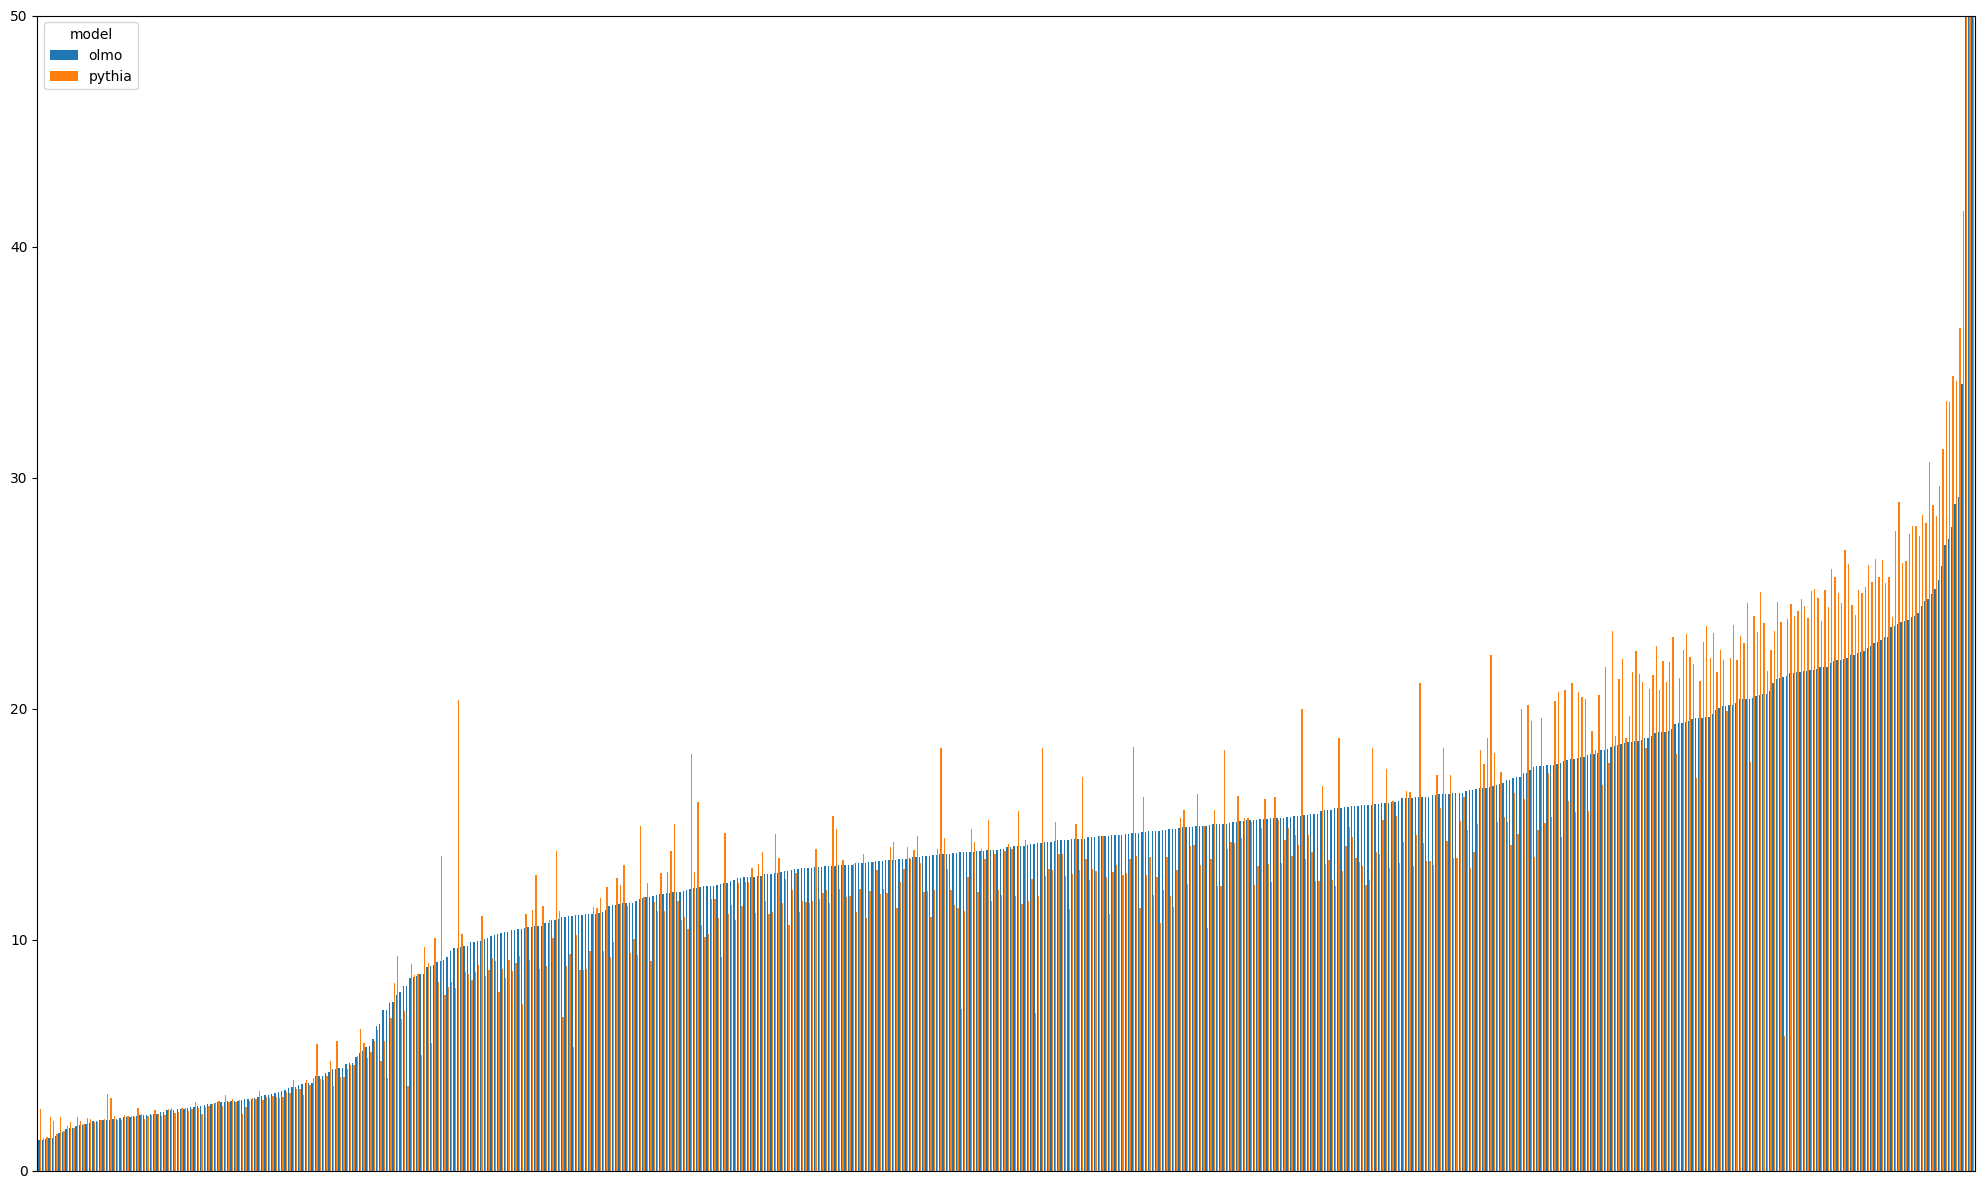

In [66]:
domain_data_by_dolma_order = all_subdomains[['model'] + domains_by_dolma_ppl].set_index('model')
ax = domain_data_by_dolma_order.T.plot.bar(width=.8, figsize=(25, 15))
# remove the x axis labels for the last plot
ax.set_xticklabels([])
# remove the x ticks too
ax.set_xticks([])
# y limit
ax.set_ylim([0, 50])

### Win rates as curves (BETA)

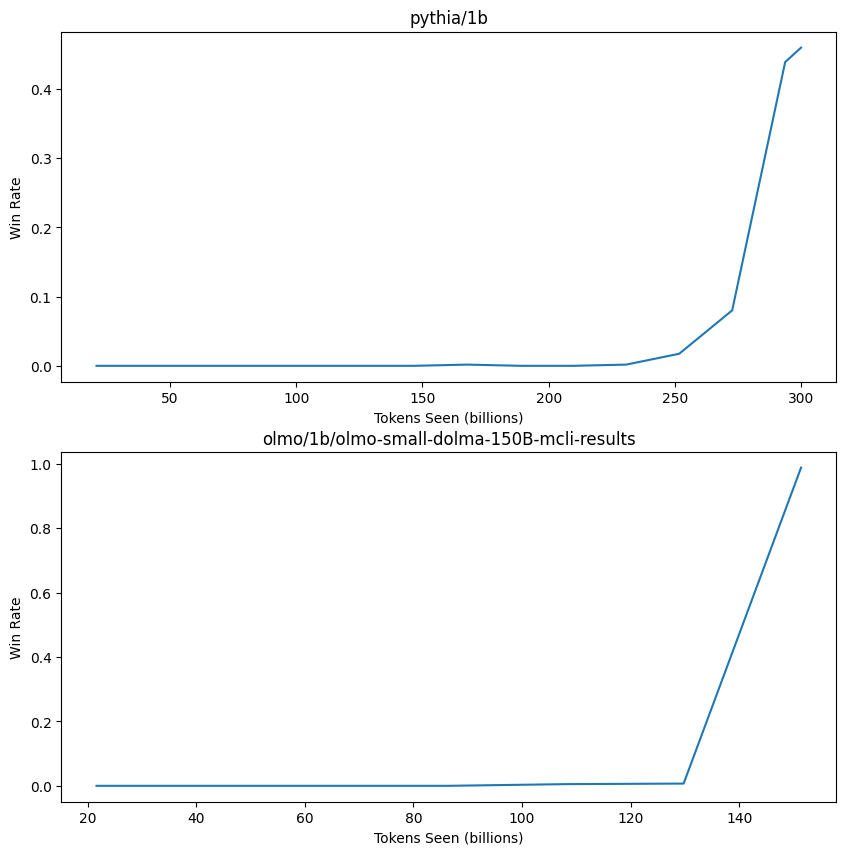

In [7]:
# win rate over training progress for each model seperately
models = [
    "pythia/1b",
    "olmo/1b/olmo-small-dolma-150B-mcli-results"
]

import matplotlib.pyplot as plt
import numpy as np

# one subplot for each model
fig, axs = plt.subplots(len(models), figsize=(10, 10))

# line chare for each model
for i, model in enumerate(models):
    model_path = os.path.join(RESULTS_DIR, model)
    all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)
    win_rate = get_win_rate_over_all_subdomains(all_subdomains)
    x_axis = win_rate['tokens_seen'] / 1000000000
    y_axis = win_rate['win_rate_over_subdomains']
    axs[i].plot(x_axis, y_axis)
    axs[i].set_title(model)
    axs[i].set_xlabel("Tokens Seen (billions)")
    axs[i].set_ylabel("Win Rate")

plt.show()



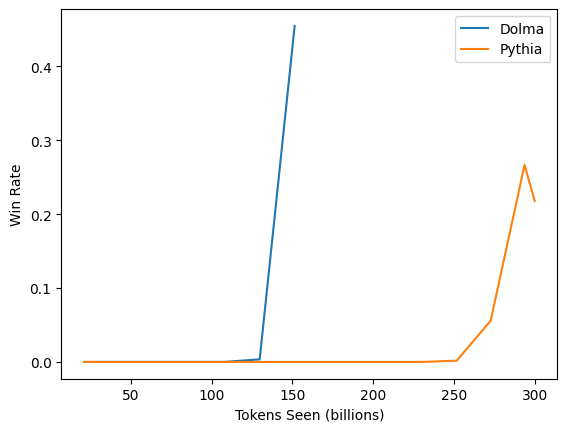

In [8]:

model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

# concat the two dataframes
all_subdomains = pd.concat([pythia_all_subdomains, dolma_all_subdomains])
win_rate = get_win_rate_over_all_subdomains(all_subdomains)

# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = win_rate[win_rate['model']=='olmo']['tokens_seen'] / 1000000000
dolma_y_axis = win_rate[win_rate['model']=='olmo']['win_rate_over_subdomains']

pythia_x_axis = win_rate[win_rate['model']=='pythia']['tokens_seen'] / 1000000000
pythia_y_axis = win_rate[win_rate['model']=='pythia']['win_rate_over_subdomains']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Tokens Seen (billions)")
plt.ylabel("Win Rate")
plt.legend()
plt.show()



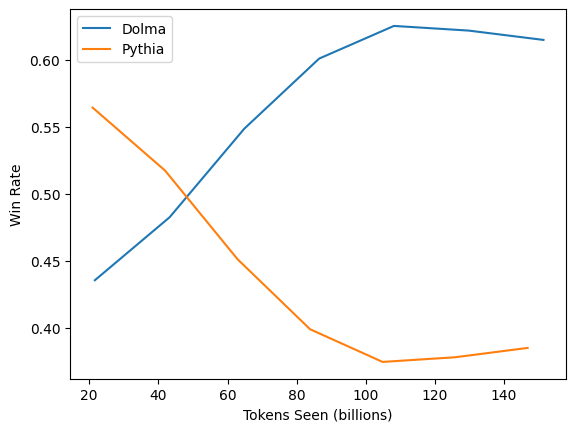

In [245]:

model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

# concat the two dataframes
all_subdomains = pd.concat([pythia_all_subdomains, dolma_all_subdomains])
win_rate = get_win_rate_over_all_subdomains_by_nearest(all_subdomains, 'tokens_seen', 10000000000)

# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = win_rate[win_rate['model']=='olmo']['tokens_seen'] / 1000000000
dolma_y_axis = win_rate[win_rate['model']=='olmo']['win_rate_with_nearest']

pythia_x_axis = win_rate[win_rate['model']=='pythia']['tokens_seen'] / 1000000000
pythia_y_axis = win_rate[win_rate['model']=='pythia']['win_rate_with_nearest']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Tokens Seen (billions)")
plt.ylabel("Win Rate")
plt.legend()
plt.show()

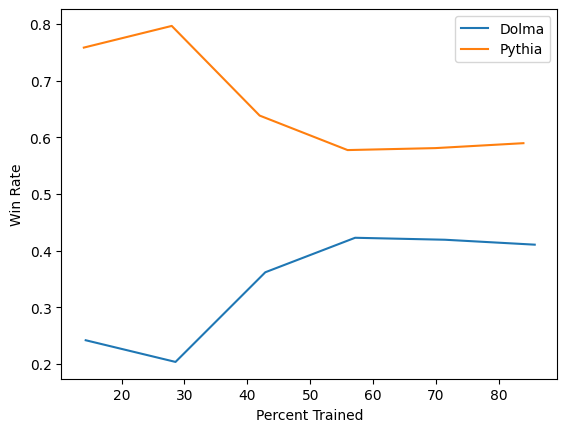

In [10]:

model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)
pythia_all_subdomains['percent_trained'] = pythia_all_subdomains['training_steps'] / pythia_all_subdomains['training_steps'].max()

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)
dolma_all_subdomains['percent_trained'] = dolma_all_subdomains['training_steps'] / dolma_all_subdomains['training_steps'].max()

# concat the two dataframes
all_subdomains = pd.concat([pythia_all_subdomains, dolma_all_subdomains])
win_rate = get_win_rate_over_all_subdomains_by_nearest(all_subdomains, 'percent_trained', .2)

# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = win_rate[win_rate['model']=='olmo']['percent_trained'] * 100
dolma_y_axis = win_rate[win_rate['model']=='olmo']['win_rate_with_nearest']

pythia_x_axis = win_rate[win_rate['model']=='pythia']['percent_trained'] * 100
pythia_y_axis = win_rate[win_rate['model']=='pythia']['win_rate_with_nearest']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Percent Trained")
plt.ylabel("Win Rate")
plt.legend()
plt.show()